KNN算法的核心思想是：如果一个样本在特征空间中的K个最相邻的样本中的大多数属于某一个类别，则该样本也属于这个类别，并具有这个类别上样本的特性。

KNN方法在类别决策时，只与极少量的相邻样本有关。由于KNN方法主要靠周围有限的邻近的样本，而不是靠判别类域的方法来确定所属类别，因此对于类域交叉或重叠较多的待分样本集来说，KNN方法较其他方法更为适合。

KNN常用的算法为：
·Brute Force；
·K-D Tree；
·Ball Tree。

In [1]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])

nbrs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(X) # 返回距离输入数据X最近的3个点的索引和距离

In [2]:
indices

array([[0, 1, 2],
       [1, 0, 2],
       [2, 1, 0],
       [3, 4, 5],
       [4, 3, 5],
       [5, 4, 3]])

In [3]:
distances

array([[0.        , 1.        , 2.23606798],
       [0.        , 1.        , 1.41421356],
       [0.        , 1.41421356, 2.23606798],
       [0.        , 1.        , 2.23606798],
       [0.        , 1.        , 1.41421356],
       [0.        , 1.41421356, 2.23606798]])

In [4]:
nbrs.kneighbors_graph(X).toarray() # 返回距离最近的3个点连接图的相应权重

array([[1., 1., 1., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0.],
       [0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1.]])

In [5]:
X = [[0], [1], [2], [3]]
y = [0, 0, 1, 1]

from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X, y)
neigh.predict([[1.1]])

array([0])

In [6]:
neigh.predict_proba([[0.9]])

array([[0.66666667, 0.33333333]])

伪装用户数据集说明：

SEA数据集涵盖了70多个UNIX系统用户的行为日志。这些数据来自于UNIX系统acct机制记录的用户使用的命令。SEA数据集中每个用户都采集了15000条命令，从用户集合中随机抽取50个用户作为正常用户，剩余用户的命令块中随机插入模拟命令作为内部伪装者攻击数据。

随机从这70多个用户中抽取50个用户，用作训练集和测试集，也就是说这50个文件中包含正常用户和伪装用户。每个文件包含15000条命令。头5000条命令是正常命令，不包含恶意的行为，后10000条命令以100个命令作为一个块划分，共分成100个块。

任何给定的命令块，在头5000条命令后都有1%的可能存在恶意命令，如果前一个块被认定为是异常行为，接下来的块就有80%的可能也是异常的，也就是说通过这种人为假定来模拟恶意用户的行为。在测试数据中也有5%的可能是恶意用户。

标记文件是一个100行，50列的数据，每列代表一个一个用户在10000个命令中每100个命令块所代表的是否存在恶意命令的情况，1表示存在恶意行为，正常为0。

对于是否是伪装用户，我们可以分析伪装用户可能会有的行为，之所以是伪装者，其拥有合法用户的认证授权，用合法权益来从事恶意活动，进一步思考，从事恶意活动，必然会存在与寻常所不同的行为，即便是管理员用户，从事恶意活动，必然会有心理压力，一般平时不怎么使用的命令，比如某些操作文件权重，设置系统资源，访问数据库的命令都会比寻常多的多，这个时候我们可以统计每个命令块中前10个命令，和后10个命令的使用数，另外比如像历史命令的清除，如history命令的使用可能会多于寻常，加之，如chown, chmod, chatter, mysql, pgsql等命令都可能会多次使用，都都可以统计其频率。

同时，我们可以使用hashvec和countvec方式将每100个命令作为一个特征向量，共150个这样的特征向量，作为输入，来训练。

chown, **chmod,** chgrp, chattr, export, **history,** **kill,** **killall,** **rmdir,** **rm,** mv, **vim,** vi, mysql, **mysqladm,** pgsql

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('classic')
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer

In [8]:
def load_user_cmd(filename):
    cmd = pd.read_csv(filename, header=None)
    dist_max = cmd[0].value_counts().head(50)
    dist_min = cmd[0].value_counts().tail(50)
    return cmd,dist_max,dist_min

In [9]:
# 特征抽取：
# 特征1：每100个命令块中去重后命令的数量
# 特征2：每100个命令块中前10个命令和所有命令前50个命令的去重后的数目统计
# 特征3：每100个命令块中后10个命令和所有命令后50个命令的去重后的数目统计
# 特征4：每100个命令块中chmod使用的次数
# 特征5：每100个命令块中history使用的次数
# 特征6：每100个命令块中kill使用的次数
# 特征7：每100个命令块中killall使用的次数
# 特征8：每100个命令块中rmdir使用的次数
# 特征9：每100个命令块中rm使用的次数
# 特征10：每100个命令块中vim使用的次数
# 特征11：每100个命令块中mysqladmin使用的次数
def get_user_cmd_feature(cmd,dist_max,dist_min):
    features = pd.DataFrame(columns=['f' + str(i) for i in range(1,12)], index=range(150))
    for i in range(0,15000,100):
        features.loc[i/100]['f1'] = len(cmd.loc[i:i+100].drop_duplicates())
        features.loc[i/100]['f2'] = len(pd.concat([cmd.loc[i:i+100].head(10),pd.DataFrame(dist_max.index)]).drop_duplicates())
        features.loc[i/100]['f3'] = len(pd.concat([cmd.loc[i:i+100].tail(10),pd.DataFrame(dist_min.index)]).drop_duplicates())
        features.loc[i/100]['f4'] = len(cmd.loc[i:i+100][cmd.loc[i:i+100][0] == 'chmod'])
        features.loc[i/100]['f5'] = len(cmd.loc[i:i+100][cmd.loc[i:i+100][0] == 'history'])
        features.loc[i/100]['f6'] = len(cmd.loc[i:i+100][cmd.loc[i:i+100][0] == 'kill'])
        features.loc[i/100]['f7'] = len(cmd.loc[i:i+100][cmd.loc[i:i+100][0] == 'killall'])
        features.loc[i/100]['f8'] = len(cmd.loc[i:i+100][cmd.loc[i:i+100][0] == 'rmdir'])
        features.loc[i/100]['f9'] = len(cmd.loc[i:i+100][cmd.loc[i:i+100][0] == 'rm'])
        features.loc[i/100]['f10'] = len(cmd.loc[i:i+100][cmd.loc[i:i+100][0] == 'vim'])
        features.loc[i/100]['f11'] = len(cmd.loc[i:i+100][cmd.loc[i:i+100][0] == 'mysqladmin'])
    return features

In [10]:
def get_label(filename, indice):
    labels = np.loadtxt(filename)
    label = np.r_[np.zeros(50),labels[:,indice-1]]
    return label

In [11]:
user_cmd,user_cmd_dist_max,user_cmd_dist_min = load_user_cmd('./数据集/masquerade/User2')

In [12]:
features = get_user_cmd_feature(user_cmd,user_cmd_dist_max,user_cmd_dist_min)

In [13]:
label = get_label("./数据集/masquerade/labels.txt", 2)
features['label'] = label.astype('int')

In [14]:
knn = KNeighborsClassifier(n_neighbors=3)
rfc = RandomForestClassifier(n_estimators=50)
knn_all = KNeighborsClassifier(n_neighbors=3)
rfc_all = RandomForestClassifier(n_estimators=50)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(features[['f1','f2','f3']],features['label'])
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(features[features.columns[:-1]],features['label'])

In [16]:
knn.fit(X_train, y_train)
rfc.fit(X_train, y_train)
knn_all.fit(X_train_all, y_train_all)
rfc_all.fit(X_train_all, y_train_all)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [17]:
knn.score(X_test, y_test)

1.0

In [18]:
rfc.score(X_test, y_test)

1.0

In [19]:
rfc.feature_importances_

array([0.50201349, 0.26869465, 0.18929186])

In [20]:
knn_all.score(X_test_all, y_test_all)

1.0

In [21]:
rfc_all.score(X_test_all, y_test_all)

1.0

In [22]:
rfc_all.feature_importances_

array([0.28866896, 0.30791928, 0.12402835, 0.        , 0.        ,
       0.        , 0.        , 0.10279077, 0.09659264, 0.        ,
       0.        ])

In [23]:
if __name__ == "__main__":
    score = pd.DataFrame(columns=['Score'], index=['User' + str(i) for i in range(1,51)])
    scores = []
    for i in range(1, 51):
        user_cmd,user_cmd_dist_max,user_cmd_dist_min = load_user_cmd('./数据集/masquerade/User' + str(i))
        features = get_user_cmd_feature(user_cmd,user_cmd_dist_max,user_cmd_dist_min)
        label = get_label("./数据集/masquerade/labels.txt", i)
        features['label'] = label.astype('int')
        rfc = RandomForestClassifier(n_estimators=50)
        X_train, X_test, y_train, y_test = train_test_split(features[['f1','f2','f3']],features['label'])
        rfc.fit(X_train, y_train)
        scores.append(rfc.score(X_test, y_test))
    score['Score'] = scores

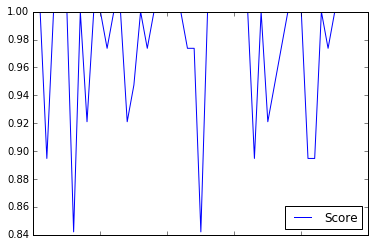

In [24]:
score.plot()

In [25]:
def get_features(filename):
    feature = open(filename, 'r').read().split('\n')
    del feature[-1]
    features = []
    string = ''
    for i in range(0,len(feature),100):
        features.append(' '.join(feature[i:i+100]))
    countvec = CountVectorizer()
    features_matrix = countvec.fit_transform(features)
    return features_matrix

In [26]:
features_matrix = get_features('./数据集/masquerade/User3')
label = get_label("./数据集/masquerade/labels.txt", 3)

X_train, X_test, y_train, y_test = train_test_split(features_matrix,label)

mnb = MultinomialNB()
mnb.fit(X_train, y_train)
mnb.score(X_test, y_test)

1.0

In [27]:
sv = SVC(kernel='linear', C=1.0)
sv.fit(X_train, y_train)
sv.score(X_test, y_test)

1.0

In [28]:
cross_val_score(sv, features, label, cv=10).mean()

0.9270238095238096

Rootkit是一种特殊的恶意软件，它的功能是在安装目标上隐藏自身及指定的文件、进程和网络链接等信息，比较常见的是Rootkit，一般都和木马、后门等其他恶意程序结合使用。这边使用KDD入侵检测数据集来检测基于telnet行为的rootkit行为，即已确定其协议和服务类型，基础的TCP内容特征，就无需加入到特征中，即只加入与文件访问，是否登录等相关特征，即取如下特征：

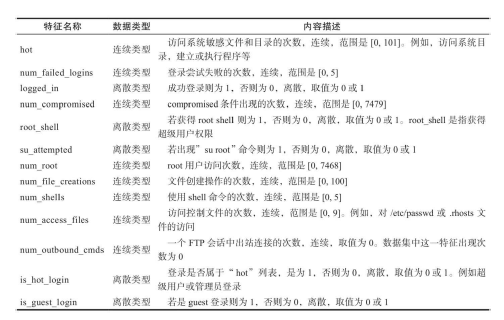

检测流程如下：

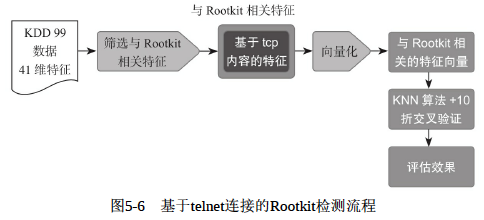

In [29]:
def load_and_get_features_label(filename, train=True, test=False):
    if train:
        kdd99_train = pd.read_csv(filename, header=None)
        rootkit_train = kdd99_train[kdd99_train[kdd99_train.columns[-1]].str.contains('normal|rootkit', regex=True)]
        features_train = rootkit_train[rootkit_train.columns[9:22]]
        label = rootkit_train[rootkit_train.columns[-1]]
        return features_train,label
    if test:
        kdd99_test = pd.read_csv(filename, header=None)
        features_test = kdd99_test[kdd99_test.columns[9:22]]
        return features_test

In [30]:
features_train, label = load_and_get_features_label('./数据集/KDD 99/kddcup.data_10_percent_corrected')

In [31]:
knn = KNeighborsClassifier(n_neighbors=3, weights='distance')
X_train, X_val, y_train, y_val = train_test_split(features_train, label)
knn.fit(X_train, y_train)
knn.score(X_val, y_val)

0.9997944248005921

In [32]:
cross_val_score(knn, features_train, label, cv=10).mean()

0.9998663767541155

In [33]:
features_test = load_and_get_features_label('./数据集/KDD 99/kddcup.testdata.unlabeled_10_percent', train=False, test=True)

In [34]:
X_test = features_test
y_predict = knn.predict(X_test)

In [35]:
y_predict[y_predict == 'rootkit']

array([], dtype=object)

使用KNN来检测webshell时，我们使用的特征是HIDS等设备对webshell攻击记录的系统调用序列，这个系统调用序列，可以转化为一个序列向量，作为特征输入。

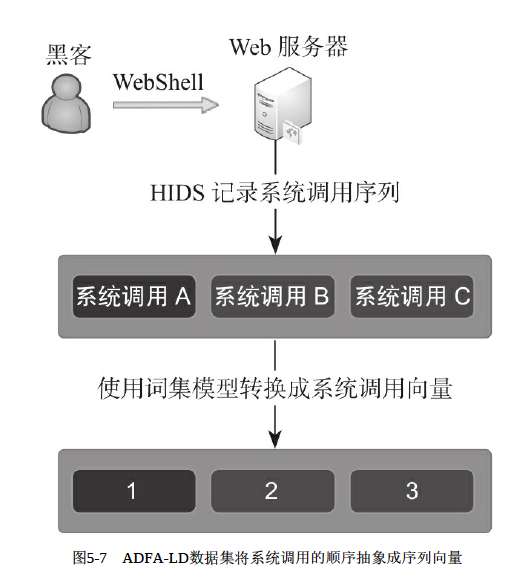

In [36]:
import glob

In [37]:
def features_and_label(path, train=True, attack=False):
    if train:
        fileList = glob.glob(path + '*.txt')
        featuresList_train = []
        for file in fileList:
            featuresList_train.append(' '.join(np.loadtxt(file).astype('int').astype('str')))
        label_train = [0] * len(fileList)
        return featuresList_train, label_train
    if attack:
        fileList = glob.glob(path + '*.txt')
        featuresList_attack = []
        for file in fileList:
            featuresList_attack.append(' '.join(np.loadtxt(file).astype('int').astype('str'))) 
        label_attack = [1] * len(fileList)
        return featuresList_attack, label_attack

In [38]:
normal, normal_label = features_and_label('./数据集/ADFA-LD/Training_Data_Master/')
attack, attack_label = features_and_label('./数据集/ADFA-LD/Attack_Data_Master/Web_Shell_*/', train=False, attack=True)

countvec = CountVectorizer()
X = countvec.fit_transform(normal + attack)
y = normal_label + attack_label

X_train, X_val, y_train, y_val = train_test_split(X, y)

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
knn.score(X_val, y_val)

0.9495798319327731

In [39]:
cross_val_score(knn, X, y, cv=10).mean()

0.9579595931317657